For this assignment you will be training a climate model emulator. The training data comes from ClimateBench (https://github.com/duncanwp/ClimateBench). This data is generated by the NorESM2 climate model. The model was run under different possible "Shared Socioeconomic Pathways" (SSPs). These SSPs correspond to different sets of actions humans can choose to take, and are therefore associated with different profiles of greenhouse gas emissions over time. Running the climate model with different GHG patterns lets us see how global climate will change based on our actions. However, as discussed in class, running climate models is computationally expensive. It is possible that machine learning can approximate these models in a less compute-intensive way.  

Your goal is to build a model that can predict temperature at specific locations in the year 2050 under different SSP scenarios. The training data comes from lat/lon pairs within the following region:
![image.png](attachment:image.png)

The training data also contains four different SSP scenarios (all of the following except for ssp245):
![image-2.png](attachment:image-2.png)

Each row in the dataset represents a lat/lon location under a specific SSP scenario. The row contains the scenario name, lat/lon coordinates, climate information from the starting year of 2015 (temperature, diurnal temperature range, precipitation, and 90th percentile precipitation), and the annual global emissions of four different GHGs each year up until the final year of 2050. Each row also contains the target value tas_FINAL, which represents the annual average temperature (given in degrees celsius relative to pre-industrial levels) for that lat/lon in the year 2050. These are the values you are trying to predict (be sure not to include it as input to your model!).

1.) Load the train_val csv and plot a histogram of tas_FINAL values (1.5pt)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

In [25]:
df = pd.read_csv('climatebench_train_val.csv')
df.head()

,scenario,lat,lon,tas_2015,pr_2015,pr90_2015,dtr_2015,tas_FINAL,CO2_2015,SO2_2015,...,CH4_2048,BC_2048,CO2_2049,SO2_2049,CH4_2049,BC_2049,CO2_2050,SO2_2050,CH4_2050,BC_2050
0,ssp126,-19.894737,0.0,0.547699,-4.770247e-07,-1.412226e-07,0.034963,0.848419,1536.072222,6.686393e-08,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
1,ssp126,-19.894737,2.5,0.648376,-2.947038e-07,-4.729113e-07,0.039381,0.737915,1536.072222,6.686393e-08,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
2,ssp126,-19.894737,5.0,0.696808,-2.691091e-07,-5.525026e-07,0.021043,0.588806,1536.072222,6.686393e-08,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
3,ssp126,-19.894737,7.5,0.721252,-4.967706e-08,-5.830042e-07,0.020420,0.522766,1536.072222,6.686393e-08,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
4,ssp126,-19.894737,10.0,0.898682,-3.642627e-07,-9.914260e-07,-0.033305,0.776642,1536.072222,6.686393e-08,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09


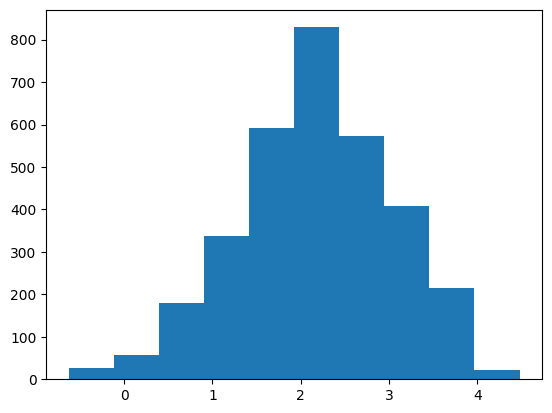

In [26]:
plt.hist(df['tas_FINAL'])
plt.show()

2.) As we discussed in class, there are many levels of generalization we can test our models on. The first is to test the model on data that comes from the same distribution as the training data. So here we will randomly split the data in train_val into training (80%) and testing (20%) data (hint: you can use https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Before you split the data, you will want to remove the 'scenario' column from the dataset, as this is a string that won't be passed into our models. (2 pts)

In [27]:
df = df.drop('scenario', axis=1)
train, test = train_test_split(df, test_size=0.2)

In [28]:
df.head()

,lat,lon,tas_2015,pr_2015,pr90_2015,dtr_2015,tas_FINAL,CO2_2015,SO2_2015,CH4_2015,...,CH4_2048,BC_2048,CO2_2049,SO2_2049,CH4_2049,BC_2049,CO2_2050,SO2_2050,CH4_2050,BC_2050
0,-19.894737,0.0,0.547699,-4.770247e-07,-1.412226e-07,0.034963,0.848419,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
1,-19.894737,2.5,0.648376,-2.947038e-07,-4.729113e-07,0.039381,0.737915,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
2,-19.894737,5.0,0.696808,-2.691091e-07,-5.525026e-07,0.021043,0.588806,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
3,-19.894737,7.5,0.721252,-4.967706e-08,-5.830042e-07,0.020420,0.522766,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
4,-19.894737,10.0,0.898682,-3.642627e-07,-9.914260e-07,-0.033305,0.776642,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09


3.) Train a random forest model (available in scikit-learn) on your training data to predict tas_FINAL. Evaluate the model by printing the score on both the training and test data. Comment on to what extent your model is "overfitting", i.e. is it doing very well on the data it was trained on but much worse on the held-out test data (5pts)

In [29]:
y = train['tas_FINAL']
X = train.drop('tas_FINAL', axis=1)
y_test = test['tas_FINAL']
X_test = test.drop('tas_FINAL', axis=1)

In [30]:
model = RandomForestRegressor()
model.fit(X, y)
pred = model.predict(X)
print(model.score(X, y))
print(model.score(X_test, y_test))

0.9912648246389965
0.9286323451287586


The model is overfitting, performing too well on the training data while can not generalize to the testing data

4.) But wait! We plotted out target value distribution, but we never looked at the distribution of our input values! Plot histograms of the four 2015 climate variables and the four emissions values (CO2, SO2, CH4, and BC) for the year 2050. (4 pts)

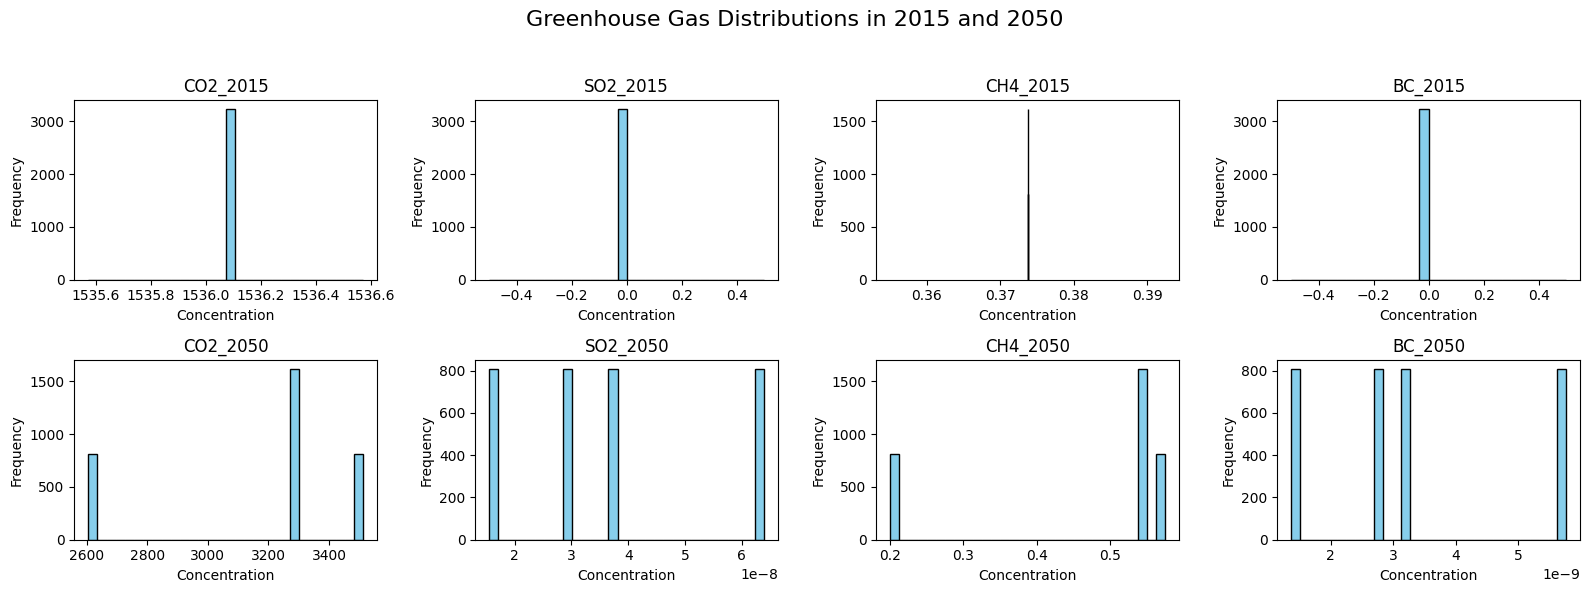

In [31]:
gases = ['CO2', 'SO2', 'CH4', 'BC']
years = ['2015', '2050']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
fig.suptitle('Greenhouse Gas Distributions in 2015 and 2050', fontsize=16)

for i, year in enumerate(years):
    for j, gas in enumerate(gases):
        ax = axes[i, j]
        col_name = f"{gas}_{year}"
        ax.hist(df[col_name], bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f'{col_name}')
        ax.set_xlabel('Concentration')
        ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


5.) Looking at these histograms we can see that the different inputs to our models are on vastly different scales! This isn't a great situation to be in. Standardize the inputs so they have zero mean and unit variance and train a new random forest model on this standardized data (hint: you can use StandardScaler with make_pipeline as shown here: https://scikit-learn.org/stable/modules/preprocessing.html). Print the training and testing score as you did before. Did standardizing help? (5 pts)

In [32]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled.var())
print(X_test_scaled.mean())

0.9755619437883736
0.018001190519421333


In [33]:
pd.DataFrame(X_test_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,6.480000e+02,6.480000e+02,6.480000e+02,648.0,...,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000
mean,-0.027780,-0.007019,0.007853,0.001841,0.033139,-0.049957,-4.547474e-13,-1.323489e-23,5.362651e-17,0.0,...,0.001129,0.019947,-0.011559,0.015506,0.001181,0.019992,-0.012269,0.015129,0.001231,0.020029
std,0.974422,0.968297,0.960581,0.988401,1.036027,1.014324,0.000000e+00,0.000000e+00,6.836261e-17,0.0,...,0.990930,1.014537,0.982651,1.015961,0.990963,1.015056,0.982174,1.016504,0.990994,1.015560
min,-1.690814,-1.629272,-2.605961,-3.142188,-2.179979,-4.368094,-4.547474e-13,-1.323489e-23,0.000000e+00,0.0,...,-1.720072,-1.243208,-1.670343,-1.192352,-1.720184,-1.220791,-1.666227,-1.170755,-1.720292,-1.198419
25%,-0.848185,-0.863217,-0.679856,-0.480539,-0.438499,-0.588448,-4.547474e-13,-1.323489e-23,0.000000e+00,0.0,...,0.493611,-0.281906,0.344889,-0.406086,0.494199,-0.304304,0.336195,-0.432850,0.494762,-0.326149
50%,-0.082159,0.094353,-0.037137,-0.259148,-0.213526,0.135205,-4.547474e-13,-1.323489e-23,0.000000e+00,0.0,...,0.493611,-0.281906,0.344889,-0.406086,0.494199,-0.304304,0.336195,-0.432850,0.494762,-0.326149
75%,0.837073,0.860409,0.620800,0.368014,0.313996,0.458195,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,0.493611,1.548349,0.344889,1.560618,0.494199,1.562033,0.336195,1.570169,0.494762,1.574922
max,1.679702,1.626465,3.134198,4.312338,5.902065,3.051853,-4.547474e-13,-1.323489e-23,1.665335e-16,0.0,...,0.733752,1.548349,0.971317,1.560618,0.732731,1.562033,0.984021,1.570169,0.731753,1.574922


In [34]:
model_standardized = RandomForestRegressor()
model_standardized.fit(X_scaled, y)
pred = model_standardized.predict(X_scaled)
print(model_standardized.score(X_scaled, y))
print(model_standardized.score(X_test_scaled, y_test))

0.9908287009758628
0.9275492057186029


Yes, but the model is still overfitting. Possible solution is to make forest less complex

6.) Now let's see if the model generalizes to locations outside of the region it was trained on. Load the spatial_test csv. This data comes from a smaller region slightly to the east of the training region:
![image.png](attachment:image.png)

Print your pre-trained (standardized) random forest model's performance on this dataset. Does the model perform as well here as it does when testing from the same region as it was trained on? (3 pts)


In [35]:
df_spatial = pd.read_csv('climatebench_spatial_test.csv').drop('scenario', axis=1)
df_spatial.head()

,lat,lon,tas_2015,pr_2015,pr90_2015,dtr_2015,tas_FINAL,CO2_2015,SO2_2015,CH4_2015,...,CH4_2048,BC_2048,CO2_2049,SO2_2049,CH4_2049,BC_2049,CO2_2050,SO2_2050,CH4_2050,BC_2050
0,31.263158,47.5,1.434113,-2.025640e-06,-0.000002,-0.179675,1.777527,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
1,31.263158,50.0,1.620880,-2.852703e-06,-0.000006,0.047719,1.763885,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
2,31.263158,52.5,1.749939,-2.216529e-06,-0.000008,0.275297,1.532257,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
3,31.263158,55.0,1.975800,-1.224600e-06,-0.000005,-0.052649,1.392151,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09
4,31.263158,57.5,1.921234,-9.459098e-07,-0.000003,-0.133629,1.440918,1536.072222,6.686393e-08,0.373737,...,0.206332,1.434831e-09,2585.223981,1.603985e-08,0.203214,1.398414e-09,2604.946519,1.547451e-08,0.200096,1.361996e-09


In [36]:
X_spatial = df_spatial.drop('tas_FINAL', axis=1)
y_spatial = df_spatial['tas_FINAL']

X_spatial_scaled = scaler.transform(X_spatial)

print(X_spatial_scaled.var())
print(X_spatial_scaled.mean())

1.0042368214669277
0.028743224873919723


In [37]:
pd.DataFrame(X_spatial_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,2.880000e+02,2.880000e+02,288.0,...,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,0.645566,2.775548,0.827862,-0.414598,-0.387477,0.316161,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,0.000226,0.003989,-0.002312,0.003101,0.000236,0.003998,-0.002454,0.003026,0.000246,0.004006
std,0.175824,0.495348,0.779811,0.249861,0.288930,0.637700,0.000000e+00,0.000000e+00,6.810534e-17,0.0,...,0.999778,1.004543,0.998150,1.004819,0.999785,1.004648,0.998057,1.004928,0.999791,1.004751
min,0.377457,2.009492,-1.413510,-1.336931,-1.401968,-1.900804,-4.547474e-13,-1.323489e-23,0.000000e+00,0.0,...,-1.720072,-1.243208,-1.670343,-1.192352,-1.720184,-1.220791,-1.666227,-1.170755,-1.720292,-1.198419
25%,0.511512,2.392520,0.345669,-0.530140,-0.543212,-0.025385,-4.547474e-13,-1.323489e-23,0.000000e+00,0.0,...,-0.059810,-0.522232,-0.158919,-0.602652,-0.059397,-0.533426,-0.164410,-0.617326,-0.059002,-0.544216
50%,0.645566,2.775548,0.895821,-0.424240,-0.389832,0.276022,-4.547474e-13,-1.323489e-23,2.775558e-17,0.0,...,0.493611,-0.144592,0.344889,-0.177930,0.494199,-0.162625,0.336195,-0.193656,0.494762,-0.180240
75%,0.779621,3.158576,1.272401,-0.264665,-0.238595,0.654124,-4.547474e-13,-1.323489e-23,8.326673e-17,0.0,...,0.553646,0.381629,0.501496,0.427823,0.553832,0.374799,0.498152,0.426696,0.554010,0.367982
max,0.913676,3.541604,2.562395,0.362786,0.877342,2.746527,-4.547474e-13,-1.323489e-23,1.665335e-16,0.0,...,0.733752,1.548349,0.971317,1.560618,0.732731,1.562033,0.984021,1.570169,0.731753,1.574922


In [38]:
model_standardized.predict(X_spatial_scaled)
print(model_standardized.score(X_spatial_scaled, y_spatial))

0.5206337547557088


The result is similar a baseline blind guess

7.) So far we have been testing the model on different locations but under the same 4 SSP scenarios it was trained on. The real value of an ML-based climate model emulator, however, is that it lets you explore new possible scenarios quickly. Let's see how this model performs on a held out SSP scenario (SSP 245). Load the scenario_test csv. This data comes from the same region the model was trained on but represents a different pattern of GHGs.

Print your pre-trained (standardized) random forest model's performance on this dataset. Does the model perform as well here as it does when testing on the SSPs it was trained on? Which was more difficult for the model: generalizing to a new spatial region or generalizing to a new scenario? (4pts)

In [39]:
df_scenario = pd.read_csv('climatebench_scenario_test.csv').drop('scenario', axis=1)
X_scenario = df_scenario.drop('tas_FINAL', axis=1)
y_scenario = df_scenario['tas_FINAL']

df_scenario.head()

,lat,lon,tas_2015,pr_2015,pr90_2015,dtr_2015,tas_FINAL,CO2_2015,SO2_2015,CH4_2015,...,CH4_2048,BC_2048,CO2_2049,SO2_2049,CH4_2049,BC_2049,CO2_2050,SO2_2050,CH4_2050,BC_2050
0,-19.894737,0.0,0.555990,-9.931833e-08,-3.426345e-07,-0.042485,0.839935,1536.072222,6.686393e-08,0.373737,...,0.347418,3.033223e-09,2907.777226,3.432615e-08,0.344846,2.978194e-09,2950.734869,3.345217e-08,0.342274,2.923164e-09
1,-19.894737,2.5,0.547587,-2.084760e-07,-5.129149e-07,-0.055545,0.800608,1536.072222,6.686393e-08,0.373737,...,0.347418,3.033223e-09,2907.777226,3.432615e-08,0.344846,2.978194e-09,2950.734869,3.345217e-08,0.342274,2.923164e-09
2,-19.894737,5.0,0.476858,-3.123266e-07,-7.148436e-07,-0.065286,0.739756,1536.072222,6.686393e-08,0.373737,...,0.347418,3.033223e-09,2907.777226,3.432615e-08,0.344846,2.978194e-09,2950.734869,3.345217e-08,0.342274,2.923164e-09
3,-19.894737,7.5,0.309591,-1.828261e-07,-8.008969e-07,-0.044665,0.824819,1536.072222,6.686393e-08,0.373737,...,0.347418,3.033223e-09,2907.777226,3.432615e-08,0.344846,2.978194e-09,2950.734869,3.345217e-08,0.342274,2.923164e-09
4,-19.894737,10.0,0.169423,-6.493187e-08,-7.357342e-07,-0.024194,0.984558,1536.072222,6.686393e-08,0.373737,...,0.347418,3.033223e-09,2907.777226,3.432615e-08,0.344846,2.978194e-09,2950.734869,3.345217e-08,0.342274,2.923164e-09


In [40]:
X_scenario_scaled = scaler.transform(X_scenario)

print(X_scenario_scaled.var())
print(X_scenario_scaled.mean())

0.16612622642025754
-0.42530546787076307


In [41]:
pd.DataFrame(X_scenario_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,8.100000e+02,8.100000e+02,8.100000e+02,810.0,...,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02
mean,-0.005556,-0.001404,-0.358546,-0.326387,-0.289000,0.094466,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,-7.554116e-01,-2.172081e-01,-6.639290e-01,-1.438029e-01,-7.728099e-01,-2.168849e-01,-6.571289e-01,-1.554822e-01,-7.894685e-01,-2.164960e-01
std,0.995467,0.994213,0.828327,0.633140,0.700970,0.831600,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,1.222000e-15,2.610636e-15,6.776545e-15,1.666363e-15,1.633036e-14,2.888363e-15,4.443636e-16,8.054090e-16,4.888000e-15,1.305318e-15
min,-1.690814,-1.629272,-2.415251,-3.266157,-3.587288,-3.353388,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,-7.554116e-01,-2.172081e-01,-6.639290e-01,-1.438029e-01,-7.728099e-01,-2.168849e-01,-6.571289e-01,-1.554822e-01,-7.894685e-01,-2.164960e-01
25%,-0.848185,-0.863217,-0.937302,-0.541077,-0.509480,-0.404816,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,-7.554116e-01,-2.172081e-01,-6.639290e-01,-1.438029e-01,-7.728099e-01,-2.168849e-01,-6.571289e-01,-1.554822e-01,-7.894685e-01,-2.164960e-01
50%,-0.005556,-0.001404,-0.320321,-0.276502,-0.217511,0.195041,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,-7.554116e-01,-2.172081e-01,-6.639290e-01,-1.438029e-01,-7.728099e-01,-2.168849e-01,-6.571289e-01,-1.554822e-01,-7.894685e-01,-2.164960e-01
75%,0.837073,0.860409,0.192117,0.014333,0.066123,0.493816,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,-7.554116e-01,-2.172081e-01,-6.639290e-01,-1.438029e-01,-7.728099e-01,-2.168849e-01,-6.571289e-01,-1.554822e-01,-7.894685e-01,-2.164960e-01
max,1.679702,1.626465,3.127083,1.507223,1.642296,2.710633,-4.547474e-13,-1.323489e-23,5.551115e-17,0.0,...,-7.554116e-01,-2.172081e-01,-6.639290e-01,-1.438029e-01,-7.728099e-01,-2.168849e-01,-6.571289e-01,-1.554822e-01,-7.894685e-01,-2.164960e-01


In [42]:
model_standardized.predict(X_scenario_scaled)
print(model_standardized.score(X_scenario_scaled, y_scenario))

0.3786540180586221


The are almost equally terrible for different scenario or location, while the the standerdized model performs even worse than blind guess over the scenario dataset.